In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal


from mixdatagenerator import MixtureDataGenerator
import seaborn as sns
%matplotlib inline

In [2]:
#
SAMPLE_SIZE = 1000
MU_1 = 0
MU_2 = 3
SIGMA_1 = 1
SIGMA_2 = 1
PROBA=0.6

mixtureObj = MixtureDataGenerator(sample_size=SAMPLE_SIZE)
y_mix = mixtureObj.gaussMixture(MU_1,MU_2,SIGMA_1,SIGMA_2,PROBA)

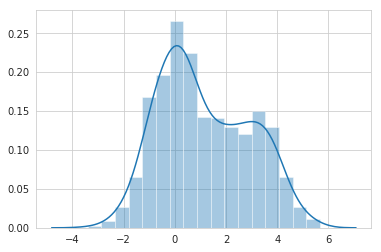

In [3]:
sns.set_style('whitegrid')
sns.distplot(y_mix)


The derivative of the log-likelihood with respect to $\mu_k$,
$$\sum_{i=1}^{n}\gamma_{Z_i}(k)\frac{(x_i-\mu_k)}{\sigma^2_k}=0$$




In [4]:
from gmm import GMM
from scipy.stats import norm

In [5]:
# Gaussian Mixture Models & EM Algorithm

## Initialize mu_1, mu_2, sigma_1, sigma_2, p_1, p_2
mus_init = np.array([0.1, 0])
sigmas_init = np.array([0.5, 1])
probas = np.array([0.35, 0.65])

In [6]:
gmmObj = GMM(k=3)

### Gaussian Mixture Model Log-likelihood

$$l(\theta) = Log(P(X_1 =x_1, \dots, X_n=x_n)) = \sum_{i=1}^{n}\sum_{k=1}^{K} \pi_k N(\mu_k, \sigma^2_k) $$

In [7]:
# 1. Evaluate log-likelihood Using Current Parameters

def density_value(x, means, sigmas):
    """ Gaussian density corresponding to a numeric vector """
    return np.array([gaussian_density_formula(x, means=mu, sigmas=sig) for mu, sig in zip(means, sigmas)])

def gaussian_density_formula(x, means, sigmas):
    """ Gaussian density  """
    return norm.pdf(x, loc=means, scale=sigmas)

def loglikelihood(x, means, sigmas,probas):
    """ Mixture Model loglikelihood """
    return np.sum(density_value(x, means=means, sigmas=sigmas).T *probas)

In [8]:
loglikelihood(x=y_mix, means=mus_init, sigmas=sigmas_init, probas=probas)

203.68163046015576

### Posteriori Distribution 
Latent variables $ Z_i $, posteriori distribution of $Z_i$ given the observation,

$$P(Z_i=k|X_i) = \frac{P(X_i|Z_i=k)P(Z_i=k)}{P(X_i)} = \frac{\pi_k N(\mu_k,\sigma_k^2)}{\sum_{k=1}^K\pi_k N(\mu_k, \sigma_k)} = \gamma_{Z_i}(k) $$

In [9]:
# 2. Compute Posteriori Distribution Using Current Parameters
def posteriori_latent(x,means,sigmas,probas):
    """ Posteriori distribiton with latent variables """

    # p_1 * N(x_i | mu_1, sigma_1) + p_2 * N(x_i | mu_2, sigma_2) +....
    # matrix (SAMPLE_SIZE x K)
    numerator = probas * density_value(x, means,sigmas).T 

    #  gaus
    # (SAMPLE_SIZE x 1)
    denominator = np.sum(probas * density_value(x, means, sigmas).T, axis=1)


    return (numerator.T/denominator).T

In [10]:
posteriori_latent(y_mix, mus_init, sigmas_init, probas)

array([[8.63515969e-10, 9.99999999e-01],
       [4.39223238e-03, 9.95607768e-01],
       [7.96935320e-06, 9.99992031e-01],
       ...,
       [5.18396225e-01, 4.81603775e-01],
       [5.17839152e-01, 4.82160848e-01],
       [5.05558399e-01, 4.94441601e-01]])

### Gaussian Mixture Model MLE

___Locations (i.e Means) Estimations:___
$$\hat\mu_k=\frac{1}{N_k}\sum_{i=1}^{n} \gamma_{Z_i}(k)x_i, \quad\textrm{ where } N_k = \sum_{i=1}^{n}\gamma_{Z_i}(k)$$



___Scale (i.e Variance) Estimations:___
$$\hat\sigma^2_k = \frac{1}{N_k}\sum_{i=1}^{n}\gamma_{Z_i}(k)(x_i-\mu_k)^2$$

___Probability Estimations:___
$$\hat p_k = \frac{N_k}{n}, \quad\textrm{ where } \sum_{k=1}^{K}\hat p_k = 1$$

*Note:*
 - $N_k$ as the effective number of points assigned to component k.
  

In [11]:
# 3. Use Current Posteriori Distro -> estimate New parameters

def mean_estimation(x, means, sigmas, probas):
    """ Mean Estimation """
    posteriori_latent_ = posteriori_latent(x, means, sigmas, probas)
    return np.sum((posteriori_latent_.T * x).T,0) / np.sum(posteriori_latent_, 0)

def sigma_estimation(x, means, sigmas, probas):
    """ Sigmas Estimation """
    posteriori_latent_ = posteriori_latent(x, means, sigmas, probas)
    
    # Because Sigma MLE depends on Means estimation
    means_estimate = mean_estimation(x, means=means, sigmas=sigmas, probas=probas)
    
    return np.sum(np.power(np.array([x - mu for mu in means_estimate]).T, 2) * posteriori_latent_,0) / np.sum(posteriori_latent_,0)

def probas_estimation(x, means, sigmas, probas):
    """ Probability Estimation """
    posteriori_latent_ = posteriori_latent(x, means, sigmas, probas)
    
    return np.sum(posteriori_latent_, axis=0)/len(posteriori_latent_)

# Note: Instead of computeing Posteriori Distribution each time, we can compute it One Time and passed it to each function

In [12]:
print("Mean Estimation ", mean_estimation(y_mix, mus_init, sigmas_init, probas))
print("Sigma Estimation ", sigma_estimation(y_mix,mus_init, sigmas_init, probas))
print("Proba Estimation ", probas_estimation(y_mix, mus_init, sigmas_init, probas))

Mean Estimation  [0.11943066 1.41029782]
Sigma Estimation  [0.32611452 3.47106151]
Proba Estimation  [0.19912438 0.80087562]


### Expected Value of the Complete log-likelihood

$$ E_{Z|X}[\log (P(X,Z|\mu,\sigma,\pi))]=  \sum_{i=1}^n \sum_{k=1}^K \gamma_{Z_i}(k)\left(\log (\pi_k) + \log (N(x_i|\mu_k, \sigma_k)) \right) $$

In [13]:
def cloglikelihood_expectation(x, means, sigmas, probas):
    """ Expected Value of the Complete log-likelihood """
    posteriori_latent_ = posteriori_latent(x, means, sigmas, probas)

    return np.sum(np.sum(np.multiply(posteriori_latent_, np.log(density_value(x, means, sigmas)).T + np.log(probas)),1))

In [14]:
cloglikelihood_expectation(y_mix, mus_init,sigmas_init,probas)

-3651.380836548824

In [15]:
# 4. Evaluate log-likelihood with the new parameter estimates
    # 4.a If log-likelihood changed by less than some small ϵ, stop. Otherwise, go back to step 2.



## Notes:
## -EM algorithm is sensitive to the initial values of the parameters
## -log-likelihood should increases at every step (assuming the initial values are “valid”)

In [30]:

mus_init = np.array([0.3, 0.4])
sigmas_init = np.array([1, 1])
probas = np.array([0.35, 0.65])
threshold = 1e-25

# Compute log-likelihood for current parametes
# Stored in log_liks


ll_init = loglikelihood(y_mix, mus_init,sigmas_init, probas)

#post_init = posteriori_latent(y_mix, mus_init, sigmas_init, probas)

expect_init = cloglikelihood_expectation(y_mix, mus_init, sigmas_init, probas)

delta = 1
log_liks = [ll_init]
expect_ = [expect_init]
means_estimates = [mus_init]
sigma_estimates = [sigmas_init]
proba_estimates = [probas]

while (delta>threshold):
    
    # Current
    mean_curr, sig_curr, proba_curr = means_estimates[-1], sigma_estimates[-1], proba_estimates[-1]
    

    # Parameters Estimation At iteration (t+1)
    means_estimate = mean_estimation(y_mix, mean_curr, sig_curr, proba_curr)
    sigma_estimate = sigma_estimation(y_mix, mean_curr, sig_curr, proba_curr)
    proba_estimate = probas_estimation(y_mix, mean_curr, sig_curr, proba_curr)
    
    means_estimates.append(means_estimate)
    sigma_estimates.append(sigma_estimate)
    proba_estimates.append(proba_estimate)
    

    # Compute E-Step
    expec_prev = expect_[-1]
    expec_curr = cloglikelihood_expectation(y_mix, means=means_estimate, sigmas=sigma_estimate, probas=proba_estimate)
    
    expect_.append(expec_curr)

    # loglikelihood
    loglike_prev = log_liks[-1]
    loglike_curr = loglikelihood(x = y_mix, means = means_estimate, sigmas=sigma_estimate, probas=proba_estimate)
    
    
    delta = abs((loglike_curr - loglike_prev))
    #delta= abs(expec_curr-expec_prev)

    log_liks.append(loglike_curr)
    

In [31]:
expect_

[-3414.8581434132248,
 -2851.7452406916227,
 -2859.4164441025064,
 -2862.039303292924,
 -2863.122737388643,
 -2863.597095548135,
 -2863.8082184841737,
 -2863.9025454676726,
 -2863.944698346004,
 -2863.963523259271,
 -2863.9719243836585,
 -2863.9756716250886,
 -2863.9773424456275,
 -2863.978087260371,
 -2863.9784192353527,
 -2863.9785671889517,
 -2863.9786331251453,
 -2863.978662509045,
 -2863.9786756035046,
 -2863.9786814387808,
 -2863.978684039138,
 -2863.9786851979225]

In [32]:
log_liks

[190.36717732253675,
 111.21389378183919,
 110.79669006578622,
 110.73075662577897,
 110.71895904049886,
 110.71672531822577,
 110.71629186509588,
 110.71620681738865,
 110.7161900398917,
 110.71618672072078,
 110.71618606302867,
 110.71618593258826,
 110.71618590670423,
 110.71618590156636,
 110.71618590054632,
 110.7161859003438,
 110.71618590030357,
 110.71618590029557,
 110.71618590029401,
 110.71618590029371,
 110.71618590029362,
 110.71618590029362]

In [33]:

means_estimates

[array([0.3, 0.4]),
 array([0.94869669, 1.25543597]),
 array([1.07929553, 1.19155814]),
 array([1.1249109 , 1.16832578]),
 array([1.14182365, 1.15942027]),
 array([1.14846822, 1.15585451]),
 array([1.15119997, 1.1543744 ]),
 array([1.15235889, 1.15374359]),
 array([1.15286052, 1.15346997]),
 array([1.15308031, 1.15334997]),
 array([1.15317731, 1.15329699]),
 array([1.15322029, 1.1532735 ]),
 array([1.15323939, 1.15326307]),
 array([1.15324788, 1.15325843]),
 array([1.15325166, 1.15325636]),
 array([1.15325335, 1.15325544]),
 array([1.1532541 , 1.15325503]),
 array([1.15325443, 1.15325485]),
 array([1.15325458, 1.15325477]),
 array([1.15325465, 1.15325473]),
 array([1.15325468, 1.15325471]),
 array([1.15325469, 1.15325471])]

In [24]:
proba_estimates

[array([0.35, 0.65]),
 array([0.33312091, 0.66687909]),
 array([0.34119501, 0.65880499]),
 array([0.34714087, 0.65285913]),
 array([0.35038397, 0.64961603]),
 array([0.35197752, 0.64802248]),
 array([0.35272443, 0.64727557]),
 array([0.35306636, 0.64693364]),
 array([0.35322098, 0.64677902]),
 array([0.35329044, 0.64670956]),
 array([0.35332153, 0.64667847]),
 array([0.35333542, 0.64666458]),
 array([0.35334162, 0.64665838]),
 array([0.35334438, 0.64665562]),
 array([0.35334562, 0.64665438]),
 array([0.35334617, 0.64665383]),
 array([0.35334641, 0.64665359]),
 array([0.35334652, 0.64665348]),
 array([0.35334657, 0.64665343]),
 array([0.35334659, 0.64665341]),
 array([0.3533466, 0.6466534]),
 array([0.3533466, 0.6466534])]

In [25]:
sigma_estimates

[array([1, 1]),
 array([2.97585035, 3.14651233]),
 array([3.02787298, 3.14908848]),
 array([3.06737987, 3.13287058]),
 array([3.08966464, 3.12172686]),
 array([3.10082774, 3.11583195]),
 array([3.10611794, 3.11298211]),
 array([3.10855536, 3.11165839]),
 array([3.1096617 , 3.11105548]),
 array([3.11015979, 3.11078363]),
 array([3.11038303, 3.11066171]),
 array([3.11048283, 3.11060719]),
 array([3.11052739, 3.11058285]),
 array([3.11054726, 3.11057199]),
 array([3.11055612, 3.11056714]),
 array([3.11056007, 3.11056499]),
 array([3.11056184, 3.11056402]),
 array([3.11056262, 3.1105636 ]),
 array([3.11056297, 3.1105634 ]),
 array([3.11056313, 3.11056332]),
 array([3.1105632 , 3.11056328]),
 array([3.11056323, 3.11056326])]